# Clustering Algorithm

In this notebook we will take the cleaned botany data *data/labeled_clean_df.csv* and use an sklearn pipeline with parameter tuning to determine the best clustering algorithm parameters.

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
from plotting import plot_geographical_positions
from cluster_pipeline import create_pipeline, custom_cv_search

In [3]:
# Import the labeled, clean dataframe created in manual_cluster_labeling.ipynb

full_df = pd.read_csv('../data/labeled_clean_df.csv', index_col=0)

In [4]:
full_df

,collectionobjectid,text1,countamt,collectingeventid,collectionobjectattachmentid,attachmentid,attachmentlocation,startdate,enddate,remarks,...,maxelevation,elevationaccuracy,latitude1,longitude1,localityname,namedplace,geographyid,cluster,startdate_num,enddate_num
36796,316747,NaN,1.0,19576.0,249495.0,249598.0,f6f0a625-3e08-4b14-89e6-246fe7dbe2f9.jpg,1824-08-19,1824-08-19,NaN,...,NaN,NaN,34.325200,-117.428100,Cajon Pass,NaN,22905.0,NaN,-4.587408e+09,-4.587408e+09
27850,239749,Low spreading shrub,1.0,24396.0,415121.0,415225.0,2dc951de-d18f-4a64-8492-8db9bff37376.jpg,1850-01-01,NaN,NaN,...,NaN,NaN,32.000000,-114.000000,Monterey,NaN,17286.0,NaN,-3.786826e+09,-9.223372e+09
36546,314625,NaN,1.0,46316.0,562709.0,562813.0,b5574eee-8e19-4d64-8919-6ac7b7f8e125.jpg,1852-07-01,1852-07-01,NaN,...,NaN,NaN,37.751400,-122.441300,San Francisco,NaN,22943.0,NaN,-3.708029e+09,-3.708029e+09
6376,54581,NaN,1.0,105965.0,373473.0,373576.0,2d4222d2-d6ea-4ae0-9416-c2de90aa10dd.jpg,1862-04-01,1862-04-01,NaN,...,NaN,NaN,37.923753,-122.597551,Near Tamalpais. Hills of Marin County.,NaN,16464.0,NaN,-3.400358e+09,-3.400358e+09
1767,14699,NaN,1.0,136720.0,191804.0,191805.0,8065b346-86a6-4127-828d-c0e07af03d87.jpg,1862-09-08,1862-09-08,NaN,...,NaN,NaN,40.962500,-122.440400,In the valley of the Upper Sacramento near 'Ji...,NaN,24800.0,NaN,-3.386534e+09,-3.386534e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15648,134324,"Cespitose, common.",1.0,104627.0,335198.0,335301.0,301d50ef-83bf-4b0a-8d35-c0d719eedf57.jpg,2010-08-10,2010-08-10,"On dry, gentle slope, forest edges and meadows...",...,2365.0,0.0,38.796667,-119.968333,"NW end of Grass Lake, W side of Luther Pass.",NaN,10339.0,NaN,1.281398e+09,1.281398e+09
9863,84415,"Cespitose, only 1 male plant seen, clumps common.",1.0,13111.0,328682.0,328785.0,e9e4e415-1bde-4318-b6d6-9cf4775a6b30.jpg,2010-08-10,2010-08-10,"Not much raised above surrounding peat, full s...",...,2365.0,0.0,38.796667,-119.968333,"NW end of Grass Lake, W side of Luther Pass.",NaN,10339.0,NaN,1.281398e+09,1.281398e+09
24001,206529,"Cespitose, common.",1.0,127449.0,338772.0,338875.0,e29a672d-8489-49ed-aad0-757b71b61286.jpg,2010-08-12,2010-08-12,"Dry, gentle slope, over volcanic pumice and du...",...,2730.0,0.0,37.650000,-119.040000,Along Route 203 above Mammoth Mountain ski lifts,NaN,17214.0,NaN,1.281571e+09,1.281571e+09
44760,688115,Epiphytic.,NaN,529612.0,211281.0,211384.0,37550c42-03cf-4e5b-8636-f68cb60e8720.jpg,2014-05-23,NaN,On trees. Montane Forest.,...,NaN,NaN,6.995833,125.253267,"Mt. Apo, EDC trail, Ilomavis, Kidapawan, North...",NaN,33645.0,NaN,1.400803e+09,-9.223372e+09


In [5]:
full_df.columns

Index(['collectionobjectid', 'text1', 'countamt', 'collectingeventid',
       'collectionobjectattachmentid', 'attachmentid', 'attachmentlocation',
       'startdate', 'enddate', 'remarks', 'localityid', 'minelevation',
       'maxelevation', 'elevationaccuracy', 'latitude1', 'longitude1',
       'localityname', 'namedplace', 'geographyid', 'cluster', 'startdate_num',
       'enddate_num'],
      dtype='object')

## 1. Simple Clustering: Spatiotemporal

First, we will build a pipeline that will transform and perform dbscan clustering on our data. We will then compare the results of this clustering against the 11 manually labeled clusters.

In [6]:
# Subset the full_df to only the columns we care about. For readability
df = df = full_df.reset_index(drop=True)[['collectingeventid', 'text1', 'startdate', 'remarks', 'latitude1', 'longitude1', 'localityname', 'cluster']]

df

,collectingeventid,text1,startdate,remarks,latitude1,longitude1,localityname,cluster
0,19576.0,NaN,1824-08-19,NaN,34.325200,-117.428100,Cajon Pass,NaN
1,24396.0,Low spreading shrub,1850-01-01,NaN,32.000000,-114.000000,Monterey,NaN
2,46316.0,NaN,1852-07-01,NaN,37.751400,-122.441300,San Francisco,NaN
3,105965.0,NaN,1862-04-01,NaN,37.923753,-122.597551,Near Tamalpais. Hills of Marin County.,NaN
4,136720.0,NaN,1862-09-08,NaN,40.962500,-122.440400,In the valley of the Upper Sacramento near 'Ji...,NaN
...,...,...,...,...,...,...,...,...
44800,104627.0,"Cespitose, common.",2010-08-10,"On dry, gentle slope, forest edges and meadows...",38.796667,-119.968333,"NW end of Grass Lake, W side of Luther Pass.",NaN
44801,13111.0,"Cespitose, only 1 male plant seen, clumps common.",2010-08-10,"Not much raised above surrounding peat, full s...",38.796667,-119.968333,"NW end of Grass Lake, W side of Luther Pass.",NaN
44802,127449.0,"Cespitose, common.",2010-08-12,"Dry, gentle slope, over volcanic pumice and du...",37.650000,-119.040000,Along Route 203 above Mammoth Mountain ski lifts,NaN
44803,529612.0,Epiphytic.,2014-05-23,On trees. Montane Forest.,6.995833,125.253267,"Mt. Apo, EDC trail, Ilomavis, Kidapawan, North...",NaN


### a. CV Search Parameter Tuning

In [23]:
# Creating this pipeline here so its parameters can be adjusted and tuned in custom_cv_search below
pipeline = create_pipeline(e_dist=0.01, e_days=30)

# Creating a parameter grid to run across the cv search. NOTE: This could be extended, made more granular
param_grid = {
    'spatial_dbscan__e_dist': [.1, 1, 5, 10, 15, 20],
    'temporal_dbscan__e_days': [3, 5, 7, 9, 10]
}

best_params, best_score, scores = custom_cv_search(df, pipeline, param_grid)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("All Scores:", scores)

Best Parameters: {'spatial_dbscan__e_dist': 10, 'temporal_dbscan__e_days': 5}
Best Score: 0.10952413973873407
All Scores: [0.6946480110436488, 0.6946480110436488, 0.6946480110436488, 0.6946480110436488, 0.6946480110436488, 0.5895188562263926, 0.5893406031069629, 0.5893406031069629, 0.5893406031069629, 0.5893406031069629, 0.2930748254142525, 0.2930748254142525, 0.2833750563611347, 1.5833750563611348, 1.57592626678944, 0.17207405559131178, 0.10952413973873407, 0.13308072172487728, 12.033080721724877, 12.033080721724877, 0.5309854857520561, 0.5776521524187228, 0.6376521524187228, 12.537652152418723, 12.537652152418723, 0.6018774348841563, 14.084929078076641, 14.14492907807664, 14.244929078076641, 14.244929078076641]


In [7]:
best_params = {'spatial_dbscan__e_dist': 10, 'temporal_dbscan__e_days': 5}

### b. Fit Pipeline with best params

In [8]:
pipeline = create_pipeline(e_dist=best_params['spatial_dbscan__e_dist'], e_days=best_params['temporal_dbscan__e_days'])

processed_df = pipeline.transform(df)

In [9]:
pipeline

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('spatial_dbscan', SpatialDBSCAN(e_dist=10)),
                ('temporal_dbscan', TemporalDBSCAN(e_days=5)),
                ('combine_clusters', CombineClusters())])

In [10]:
pipeline = create_pipeline(e_dist=10, e_days=10)
processed_df = pipeline.transform(df)

for i in np.arange(0, 11):
    df1 = processed_df[processed_df.cluster == i]
    stc_id = df1.iloc[0].spatiotemporal_cluster_id
    print('clust', i, '- manual size: ', len(df1), ', algorithm size: ', len(processed_df[processed_df.spatiotemporal_cluster_id == stc_id]))

clust 0 - manual size:  193 , algorithm size:  194
clust 1 - manual size:  8 , algorithm size:  8
clust 2 - manual size:  1 , algorithm size:  120
clust 3 - manual size:  537 , algorithm size:  380
clust 4 - manual size:  1122 , algorithm size:  341
clust 5 - manual size:  43 , algorithm size:  43
clust 6 - manual size:  852 , algorithm size:  852
clust 7 - manual size:  433 , algorithm size:  579
clust 8 - manual size:  3 , algorithm size:  3
clust 9 - manual size:  15 , algorithm size:  15
clust 10 - manual size:  742 , algorithm size:  718


### c. Visual Inspection

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


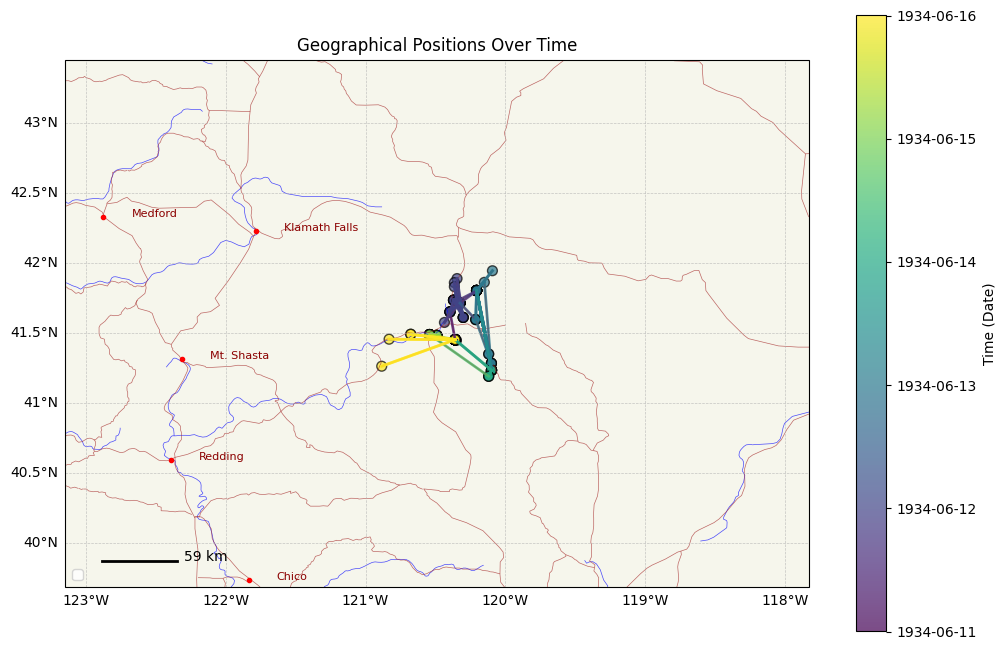

In [19]:
i = 0

stc_id = processed_df[processed_df.cluster == i].iloc[0].spatiotemporal_cluster_id

plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == stc_id], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, )

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


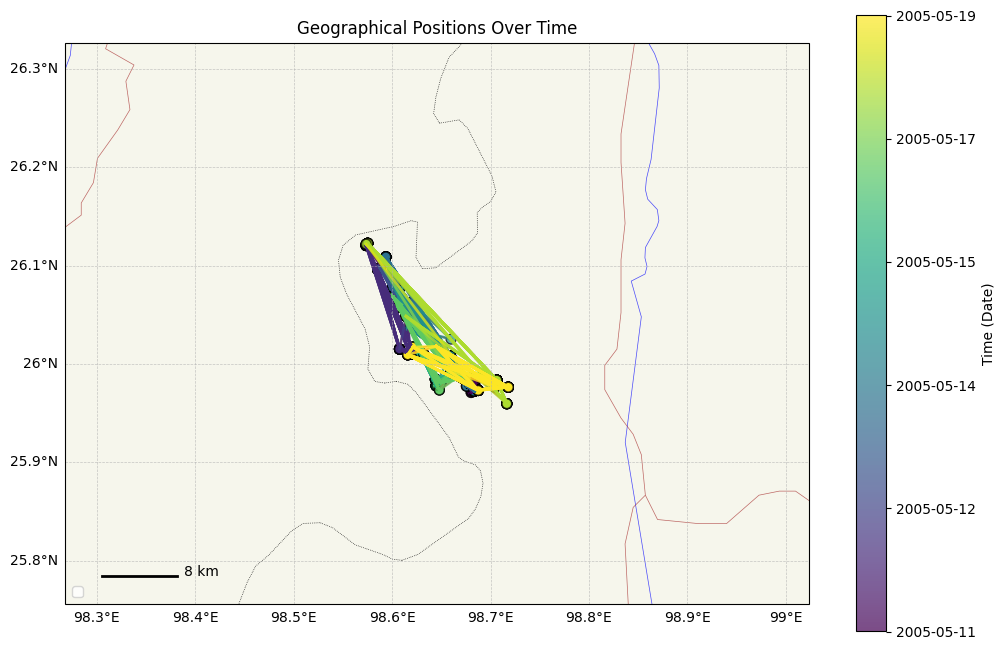

In [23]:
i = 6

stc_id = processed_df[processed_df.cluster == i].iloc[0].spatiotemporal_cluster_id

plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == stc_id], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.8, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, )

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


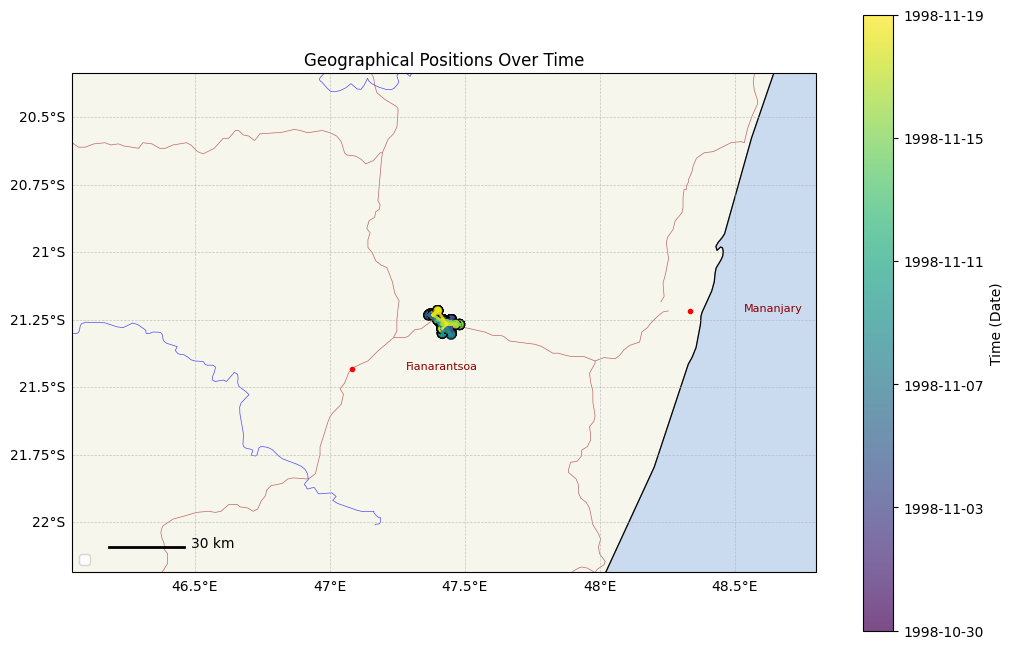

In [25]:
i = 10

stc_id = processed_df[processed_df.cluster == i].iloc[0].spatiotemporal_cluster_id

plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == stc_id], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.1, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, )

In [27]:
biggest_clusters = processed_df.groupby('spatiotemporal_cluster_id').size().sort_values(ascending=False).head(20)
biggest_clusters

spatiotemporal_cluster_id
5637    2330
5533    1529
5588    1480
4434    1436
5434    1238
5622    1181
5577     988
5364     865
5572     852
5169     849
5494     781
5062     718
5304     616
5586     579
4262     430
5057     391
5058     380
5493     341
1962     326
5049     293
dtype: int64

np.int64(5637)

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


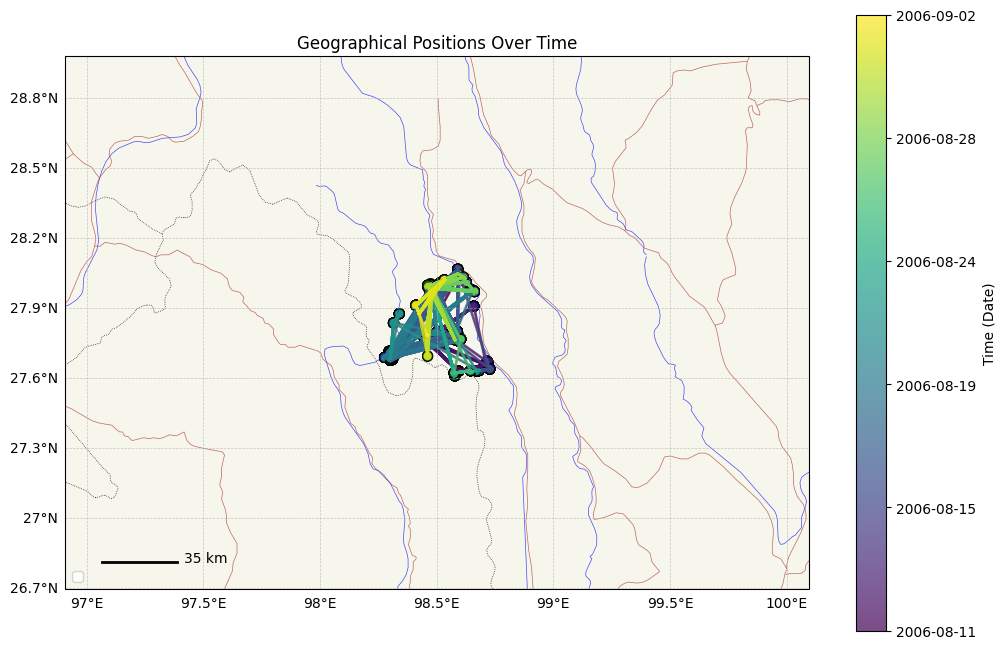

In [32]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[0]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)


/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


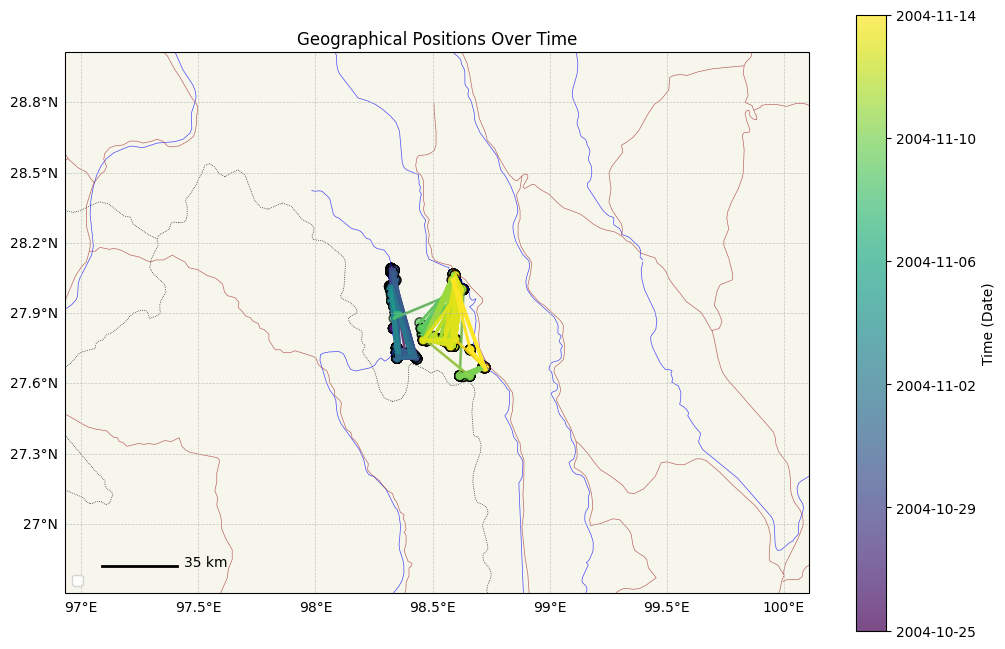

In [33]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[1]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)


/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


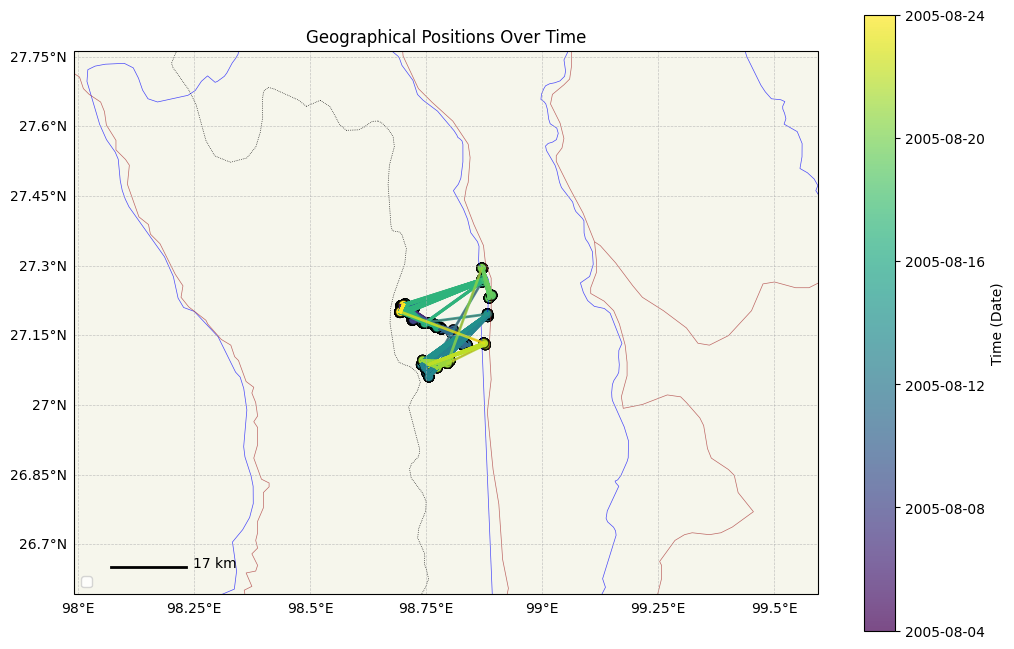

In [34]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[2]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)
                            # zoom='auto', cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)


/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


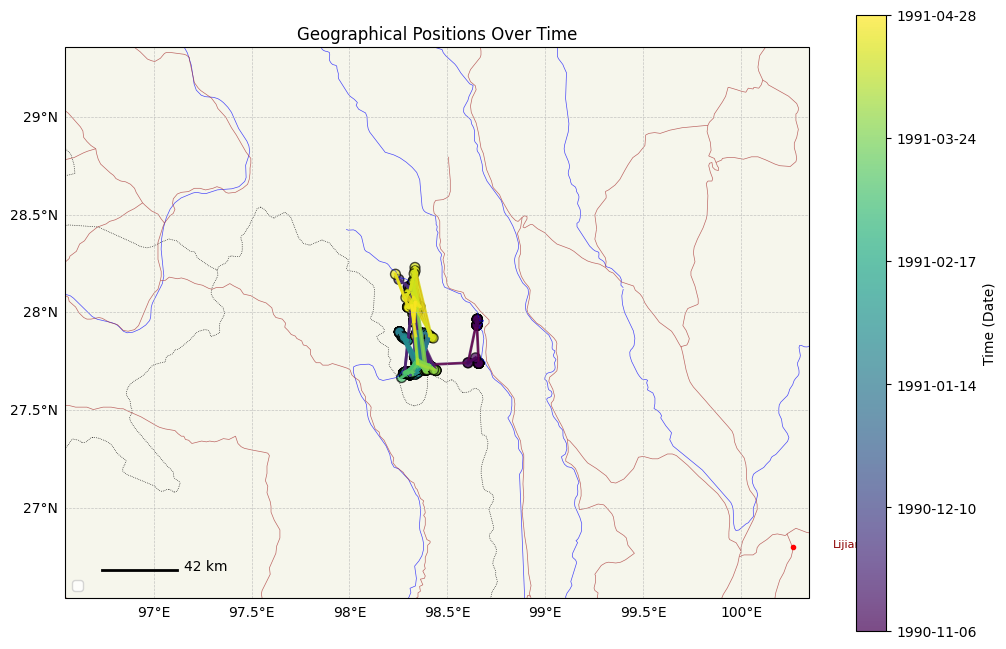

In [35]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[3]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


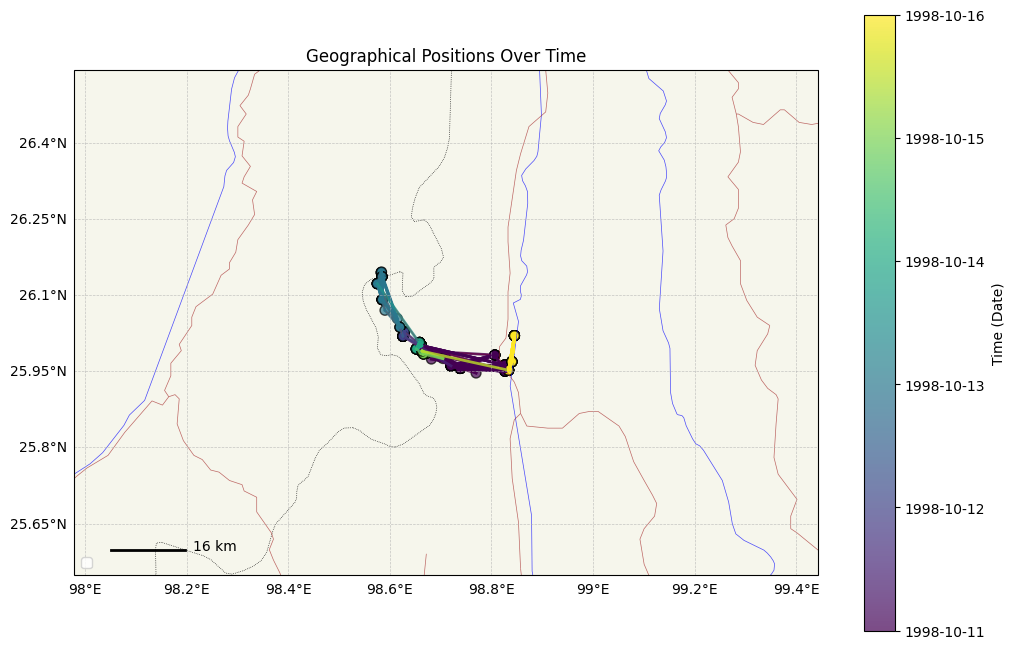

In [39]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[19]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)

/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: Legend does not support handles for FeatureArtist instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='lower left', fontsize=10)
/Users/dangause/Desktop/calacademy/expedition-clustering/plotting.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower left', fontsize=10)


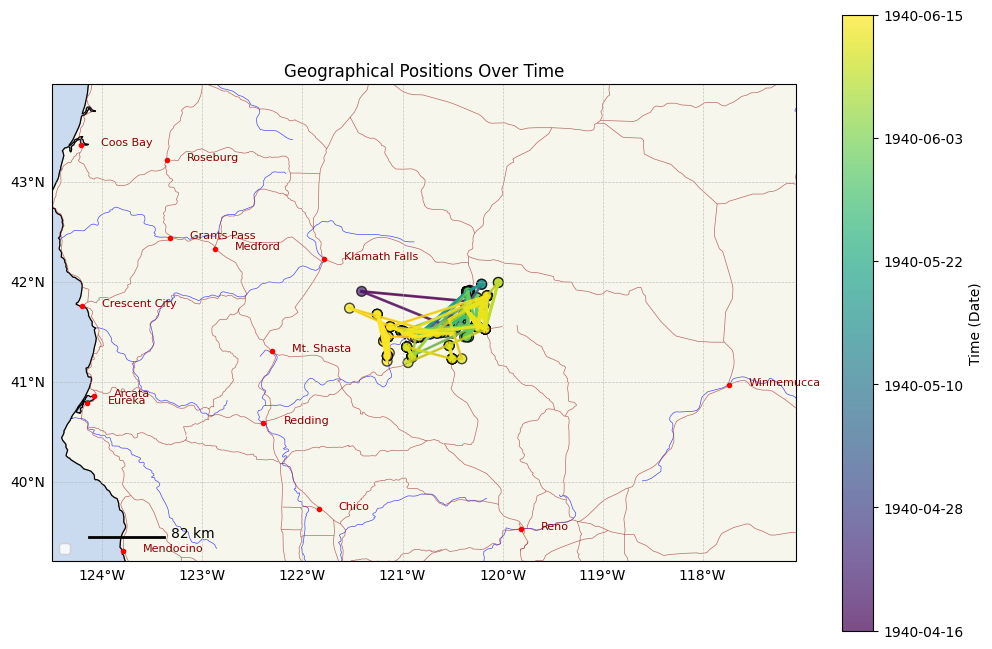

In [40]:
plot_geographical_positions(processed_df[processed_df.spatiotemporal_cluster_id == biggest_clusters.index[18]], lat_col='latitude1', lon_col='longitude1', datetime_col='startdate',\
                            zoom=0.5, cluster_line=True, plot_towns=True, plot_rivers=True, plot_roads=True)

This one is questionable! I feel like this likely is a number of clusters since its over a period of 2 months... 